In [8]:
# Cell 1: imports & plotting setup

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Basic plotting style (NMI-like: clean, no top/right spines)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["font.size"] = 9
plt.rcParams["legend.frameon"] = False

tables_dir = os.path.join("..", "results", "tables")
csv_path = os.path.join(tables_dir, "exp11_shape_texture_pier.csv")
df = pd.read_csv(csv_path)

df.head()

,ContextType,ContextLabel,TargetModel,Group,Dose,MeanPIER,StdPIER,NumEvalPoints,NumFitPoints,ContextRawSize
0,dataset,texture_natural,ResNet50,Standard CNN,0.0,0.000274,0.000197,400,400,800
1,dataset,texture_natural,EfficientNetB0,Standard CNN,0.0,0.000076,0.000192,400,400,800
2,dataset,texture_natural,ConvNeXtTiny,Standard CNN,0.0,0.000083,0.000086,400,400,800
3,dataset,texture_natural,ViT_B16,Standard CNN,0.0,0.000057,0.000092,400,400,800
4,dataset,texture_natural,ShapeResNet50_SIN,Shape-biased CNN,0.0,0.000089,0.000241,400,400,800


In [9]:
# Cell 2: small helper to enforce a consistent model order and colors

model_order = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",          # variant A: SIN only
    "ShapeResNet50_SININ",        # variant B: SIN + IN
    "ShapeResNet50_ShapeResNet",  # variant C: SIN+IN then finetuned on IN
]

color_map = {
    "ResNet50": "tab:orange",
    "EfficientNetB0": "tab:green",
    "ConvNeXtTiny": "tab:red",
    "ViT_B16": "tab:purple",
    "ShapeResNet50_SIN": "tab:blue",
    "ShapeResNet50_SININ": "tab:brown",
    "ShapeResNet50_ShapeResNet": "tab:pink",  
}

def order_models(sub_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add a temporary 'Order' column based on `model_order`,
    sort by it, then drop the helper column.

    Models not in `model_order` are pushed to the end (in original order).
    """
    sub = sub_df.copy()
    order_dict = {m: i for i, m in enumerate(model_order)}

    # For models not in model_order, assign a large order number to avoid NaN issues
    sub["Order"] = sub["TargetModel"].map(order_dict).fillna(len(model_order)).astype(int)
    sub = sub.sort_values("Order")
    sub = sub.drop(columns=["Order"])
    return sub


In [10]:
# Cell 3: aggregate mean PIER per context and model

agg = (
    df.groupby(["ContextLabel", "TargetModel"])["MeanPIER"]
    .mean()
    .reset_index()
)

texture_df = order_models(agg[agg["ContextLabel"] == "texture_natural"])
shape_df   = order_models(agg[agg["ContextLabel"] == "shape_bias"])

texture_df, shape_df


(       ContextLabel                TargetModel  MeanPIER
 9   texture_natural                   ResNet50  0.000274
 8   texture_natural             EfficientNetB0  0.000076
 7   texture_natural               ConvNeXtTiny  0.000083
 13  texture_natural                    ViT_B16  0.000057
 10  texture_natural          ShapeResNet50_SIN  0.000089
 11  texture_natural        ShapeResNet50_SININ  0.000089
 12  texture_natural  ShapeResNet50_ShapeResNet  0.000073,
   ContextLabel                TargetModel  MeanPIER
 2   shape_bias                   ResNet50  0.000406
 1   shape_bias             EfficientNetB0  0.000344
 0   shape_bias               ConvNeXtTiny  0.000788
 6   shape_bias                    ViT_B16  0.000297
 3   shape_bias          ShapeResNet50_SIN  0.000432
 4   shape_bias        ShapeResNet50_SININ  0.000318
 5   shape_bias  ShapeResNet50_ShapeResNet  0.000739)

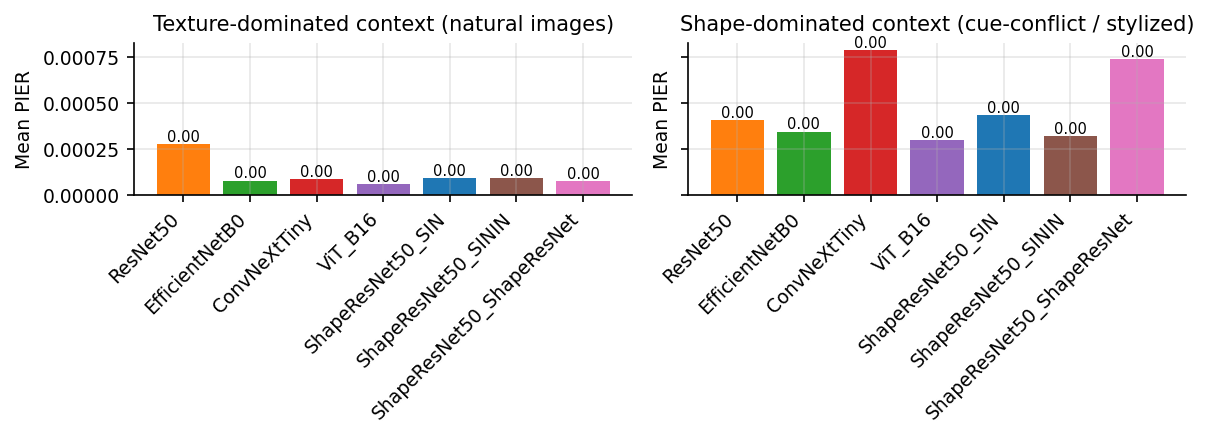

In [11]:
# Cell 4: barplots for texture vs shape contexts (two panels)

fig, axes = plt.subplots(1, 2, figsize=(8, 3.0), sharey=True)

for ax, (sub_df, title) in zip(
    axes,
    [
        (texture_df, "Texture‑dominated context (natural images)"),
        (shape_df,   "Shape‑dominated context (cue‑conflict / stylized)"),
    ],
):
    models = sub_df["TargetModel"].tolist()
    vals = sub_df["MeanPIER"].values
    x = np.arange(len(models))
    colors = [color_map[m] for m in models]

    ax.bar(x, vals, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.set_ylabel("Mean PIER")
    ax.set_title(title, fontsize=10)

    for xi, v in zip(x, vals):
        ax.text(xi, v, f"{v:.2f}", ha="center", va="bottom", fontsize=7)

    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# Cell 5: delta PIER (shape context minus texture context) per model

# Merge the two contexts into a wide table
wide = texture_df[["TargetModel", "MeanPIER"]].rename(
    columns={"MeanPIER": "PIER_Texture"}
).merge(
    shape_df[["TargetModel", "MeanPIER"]].rename(
        columns={"MeanPIER": "PIER_Shape"}
    ),
    on="TargetModel",
    how="inner",
)

wide["Delta_PIER"] = wide["PIER_Shape"] - wide["PIER_Texture"]
wide = order_models(wide)

wide


,TargetModel,PIER_Texture,PIER_Shape,Delta_PIER
0,ResNet50,0.000274,0.000406,0.000132
1,EfficientNetB0,0.000076,0.000344,0.000268
2,ConvNeXtTiny,0.000083,0.000788,0.000704
3,ViT_B16,0.000057,0.000297,0.000240
4,ShapeResNet50_SIN,0.000089,0.000432,0.000344
5,ShapeResNet50_SININ,0.000089,0.000318,0.000228
6,ShapeResNet50_ShapeResNet,0.000073,0.000739,0.000666


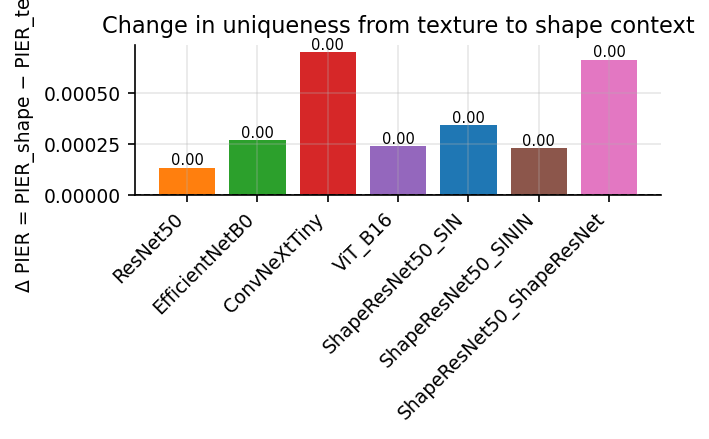

In [13]:
# Cell 6: delta barplot (one panel)

models = wide["TargetModel"].tolist()
vals = wide["Delta_PIER"].values
x = np.arange(len(models))
colors = [color_map[m] for m in models]

plt.figure(figsize=(4.5, 3.0))
plt.bar(x, vals, color=colors)
plt.axhline(0.0, color="black", linewidth=0.8, linestyle="--")

plt.xticks(x, models, rotation=45, ha="right")
plt.ylabel("Δ PIER = PIER_shape − PIER_texture")
plt.title("Change in uniqueness from texture to shape context")

for xi, v in zip(x, vals):
    plt.text(xi, v, f"{v:.2f}", ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.show()


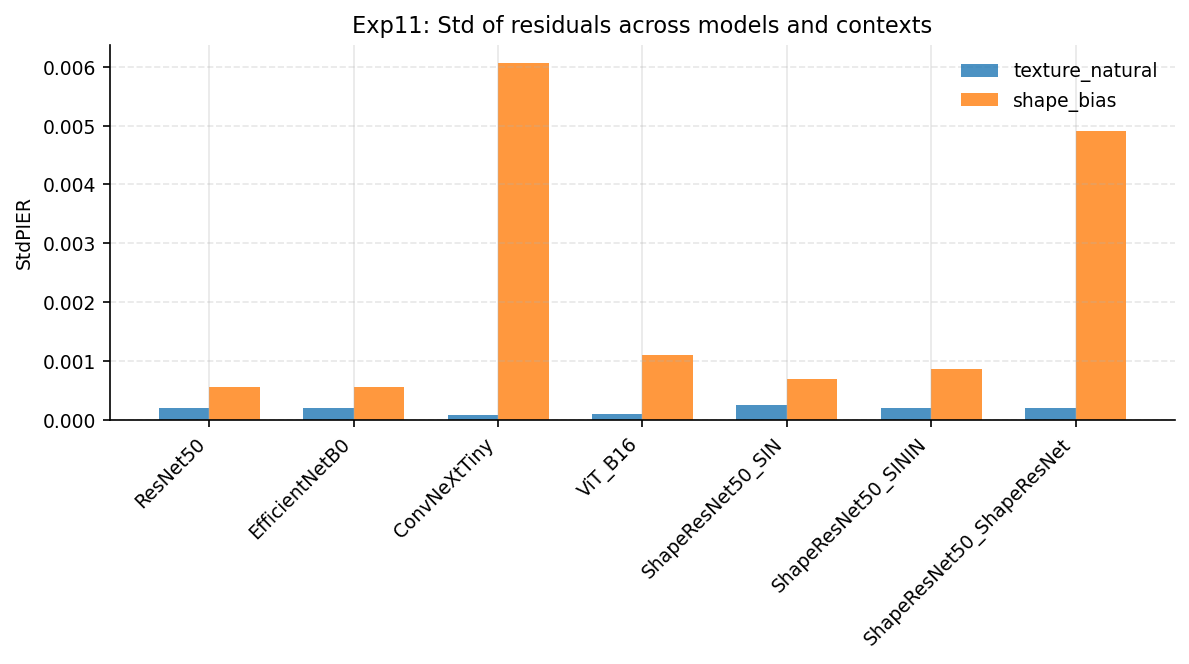

In [14]:
# 固定模型顺序，方便对照
model_order = [
    "ResNet50",
    "EfficientNetB0",
    "ConvNeXtTiny",
    "ViT_B16",
    "ShapeResNet50_SIN",
    "ShapeResNet50_SININ",
    "ShapeResNet50_ShapeResNet",
]

context_order = ["texture_natural", "shape_bias"]

def order_models(sub_df: pd.DataFrame) -> pd.DataFrame:
    sub = sub_df.copy()
    order_dict = {m: i for i, m in enumerate(model_order)}
    sub["__order"] = sub["TargetModel"].map(order_dict).fillna(len(model_order)).astype(int)
    return sub.sort_values("__order").drop(columns=["__order"])


# 按 (模型, context) 聚合 StdPIER（其实每组只有一行，这里是保险）
std_pivot = (
    df.groupby(["TargetModel", "ContextLabel"])["StdPIER"]
    .mean()
    .reset_index()
)
std_pivot = order_models(std_pivot)

fig, ax = plt.subplots(figsize=(8, 4.5))

x = range(len(model_order))
width = 0.35

for i, ctx in enumerate(context_order):
    sub = std_pivot[std_pivot["ContextLabel"] == ctx].set_index("TargetModel").reindex(model_order)
    heights = sub["StdPIER"].values
    ax.bar(
        [xx + (i - 0.5) * width for xx in x],
        heights,
        width=width,
        label=ctx,
        alpha=0.8,
    )

ax.set_xticks(list(x))
ax.set_xticklabels(model_order, rotation=45, ha="right")
ax.set_ylabel("StdPIER")
ax.set_title("Exp11: Std of residuals across models and contexts")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()
